# Определение возраста покупателей

## Исследовательский анализ данных

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


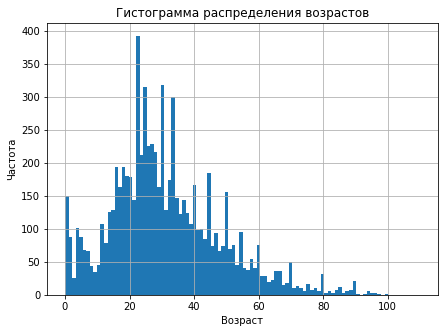

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


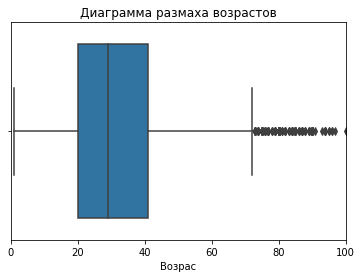

In [5]:
labels.plot(y = 'real_age', kind = 'hist', bins = 100, grid=True, figsize = (7,5), range = (0,110), legend=None)
plt.title('Гистограмма распределения возрастов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()
sns.boxplot(labels['real_age'])
plt.title('Диаграмма размаха возрастов')
plt.xlabel('Возрас')
plt.xlim(0, 100)
plt.show()

Преобладающий возраст людей на фотографиях 20-40 лет. Есть правал на графике в районе 10 лет. Скорее всего в сете мало фотографий подростков.

In [6]:
sample_images, _ = next(train_gen_flow)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

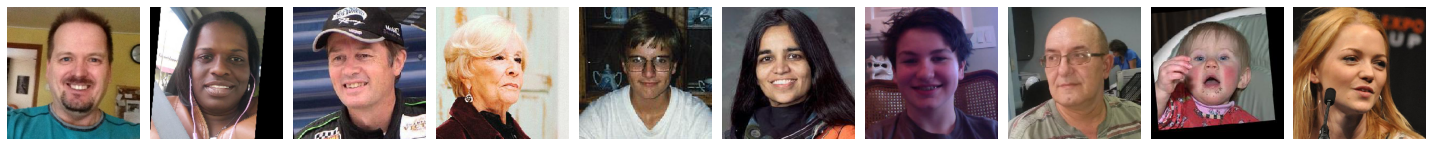

In [8]:
plotImages(sample_images)

В датасете действительно представлены фотографии людей разных рас,возрастов,пола. Фотографии отличаются качеством, освещением, ракурсами.

Скорее всего модель с высокой точностью научится определять возраст людей в диапазоне 20-40 лет. т.к. таких данных в сете больше всего. Точность модели для других возрастных групп может быть ниже из-за нехватки данных.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [9]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Данные о работе модели в тренажёре

Train for 356 steps, validate for 119 steps
Epoch 1/10

356/356 - 61s - loss: 208.9566 - mae: 10.5021 - val_loss: 544.6074 - val_mae: 18.2569
Epoch 2/10
356/356 - 38s - loss: 89.6293 - mae: 7.1350 - val_loss: 124.4393 - val_mae: 8.6656
Epoch 3/10
356/356 - 38s - loss: 59.8785 - mae: 5.9234 - val_loss: 102.7650 - val_mae: 7.4179
Epoch 4/10
356/356 - 38s - loss: 44.6387 - mae: 5.0947 - val_loss: 86.7133 - val_mae: 6.9360
Epoch 5/10
356/356 - 38s - loss: 32.0909 - mae: 4.3642 - val_loss: 122.2333 - val_mae: 8.8426
Epoch 6/10
356/356 - 38s - loss: 23.8698 - mae: 3.7425 - val_loss: 71.4771 - val_mae: 6.3430
Epoch 7/10
356/356 - 38s - loss: 20.6665 - mae: 3.4556 - val_loss: 67.9834 - val_mae: 6.0796
Epoch 8/10
356/356 - 38s - loss: 16.9704 - mae: 3.1332 - val_loss: 70.7720 - val_mae: 6.1830
Epoch 9/10
356/356 - 38s - loss: 13.6724 - mae: 2.8294 - val_loss: 67.2168 - val_mae: 6.0465
Epoch 10/10
356/356 - 38s - loss: 13.2886 - mae: 2.7803 - val_loss: 63.8177 - val_mae: 5.8350

119/119 - 9s - loss: 63.8177 - mae: 5.8350
Test MAE: 5.8350

## Анализ обученной модели

**Общий вывод:**  Показатель МАЕ на тестовой выборке 5.8 На обучающей выборке показатель МАЕ удалось довести до 2.7 при значение Epoch = 10. 
В общем можно сделать вывод, что обученная модель позволяет с высокой точностью предсказывать возраст покупателей.  